# Lab 5: Metropolis Hastings Sampling
Welcome to the fifth DS102 lab! 

The goals of this lab is to get a better understanding of the Metropolis Hastings sampling algorithm.

The code you need to write is commented out with a message "TODO: fill in". There is additional documentation for each part as you go along.


## Course Policies

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Submission**: to submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Thursday February 27, 2020 at 11:59 PM.** 

Write collaborator names here.

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
from itertools import product

Populating the interactive namespace from numpy and matplotlib


# 1) Sampling from a bimodal mixture of 1-dimensional Gaussians
Metropolis Hastings is a Markov Chain Monte Carlo (MCMC) type algorithm that allows us to draw samples from arbitrary probability distributions. The difficulty of sampling from these distributions, and the success of the Metropolis Hastings algorithm, varies depending on the distribution. In particular, this difficulty can depend on how "bumpy" the distribution is and the dimensionality of the distribution. 

We will observe some of these difficulties in this lab by attempting to sample from a bimodal mixture of Gaussian distributions using Metropolis Hastings. 

We will start with 1-dimensional Gaussian distributions. For $x \in \mathbb{R}$, the probably density function that we want to sample from is $$f(x) = \frac{1}{2} \phi_1(x) + \frac{1}{2} \phi_2(x), $$ where $\phi_1$ and $\phi_2$ are each probability density functions for Gaussian distributions with means $\mu_1$ and $\mu_2$ and standard deviations $\sigma_1$ and $\sigma_2$ respectively.

Specifically, given means $\mu_1$, $\mu_2 \in \mathbb{R}$ and standard deviations $\sigma_1, \sigma_2 \in \mathbb{R}$, we have
$$\phi_1(x) = \frac{1}{\sigma_1\sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - \mu_1}{\sigma_1}\right)^2}$$ and 
$$\phi_2(x) = \frac{1}{\sigma_2\sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - \mu_2}{\sigma_2}\right)^2}.$$

In [2]:
# Define the pdf that we want to sample from, f(x).
# No TODOs here, just run this cell to initialize the pdf we want to sample from.
def objective_f_1d(x, mu_1=-1, mu_2=1, sigma_1=0.3, sigma_2=0.3, weight_1 = 0.5, weight_2 = 0.5):
    """pdf for a 1-dimensional bimodal mixture of Gaussians distribution."""
    return weight_1*scipy.stats.norm.pdf(x, mu_1, sigma_1) + weight_2*scipy.stats.norm.pdf(x, mu_2, sigma_2)

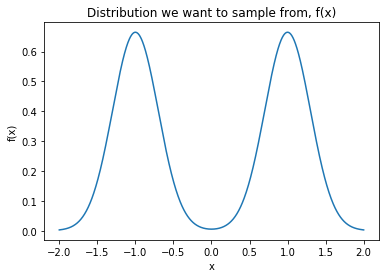

In [3]:
# Plot the distribution that we want to sample from, f(x).
# No TODOs here, just run this cell to visualize f(x).
plt.title("Distribution we want to sample from, f(x)")
idxs = np.linspace(-2, 2,num=1000)
plt.plot(idxs, [objective_f_1d(i) for i in idxs])
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

## 1a) Proposal distribution for Metropolis Hastings
Now let's define the proposal distribution that our Metropolis Hastings algorithm will use.

Recall that Metropolis Hastings views the sampling process as sequential: we will choose an initial sample, and every next sample is going to depend on the previous sample. This is done through a proposal distribution $v(x'|x)$, which given the previous sample $x$ defines a probability distribution over the new sample $x'$. In this case let's pick a Gaussian proposal distribution:
$$v(x'|x) = \mathcal{N}(x'; x, \sigma).$$
The proposal distribution $v(x'|x)$ has mean $x$ and standard deviation $\sigma$. The mean $x$ comes from the previous sample, and the standard deviation $\sigma$ is something we have to choose manually. We will try out different values for $\sigma$ later.

Recall also that we don't always accept the new proposed sample. There's a chance our new sample is simply going to be set to our old sample $x' = x$. The probability $\alpha$ of us accepting the new sample is given by
$$\min{\left(1, \frac{f(x')v(x|x')}{f(x)v(x'|x)}\right)},$$
where $f: \mathbb{R} \to \mathbb{R}$ is the pdf we wish to sample from.

Below we've implemented most functions but have left the function that computes $\alpha$ empty for you to complete.

In [4]:
def draw_from_proposal_distribution(x, sigma, d_input=1):
    """Given the previous sample x, draws a new sample from v(x_prime|x).
    
    This function draws from a 1 dimensional gaussian distribution.
    
    Args:
      x : The previous sample on which we are conditioning. Can be a float or a d-dimensional numpy array.
      sigma : float, the standard deviation of our proposal distribution. In d-dimensions, the covariance matrix will 
        be the identity matrix * sigma**2.
    
    Returns:
      x_prime : float, the generated proposed next state.
    """
    if d_input == 1:
        return np.random.normal(x, sigma)
    else: 
        return np.random.multivariate_normal(x, (sigma**2)*np.identity(d_input))


def pdf_proposal_distribution(x_prime, x, sigma):
    """Given the previous sample x and new sample x_prime, computes v(x_prime|x).
    
    Args:
      x_prime : The new sample at which we are evaluating the pdf. Can be a float or a d-dimensional numpy array.
      x : The previous sample on which we are conditioning. Can be a float or a d-dimensional numpy array.
      sigma : float, the standard deviation of our proposal distribution. In d-dimensions, the covariance matrix will 
        be the identity matrix * sigma**2.
    
    Returns:
      v : float, the value of v(x_prime|x).
    """
    return scipy.stats.multivariate_normal.pdf(x_prime, x, sigma**2)


def accept_probability(x_prime, x, sigma, objective_f_input):
    """Computes the probability of accepting a new proposed sample given the previous sample.
    
    Args:
      x_prime : The new proposed sample. Can be a float or a d-dimensional numpy array.
      x : The previous sample from which we generated the new sample. Can be a float or a d-dimensional numpy array.
      sigma : float, the standard deviation of our proposal function. In d-dimensions, the covariance matrix will 
        be the identity matrix * sigma**2.
        
    Returns:
      alpha : float, the probability we will accept the proposed sample.
    """
    frac = (objective_f_input(x_prime)* pdf_proposal_distribution(x, x_prime, sigma) /
            (objective_f_input(x) * pdf_proposal_distribution(x_prime, x, sigma)))
    return np.minimum(1, frac)


def true_with_probability_alpha(alpha):
    """Randomly returns True with probability alpha, otherwise returns False."""
    return np.random.binomial(1, alpha) == 1

## 1b) Implementing Metropolis Hastings
Now that we've defined our proposal distribution, we can actually implement Metropolis Hastings. We've implemented most of the algorithm for you. You only need to fill in the TODOs.

In [5]:
def metropolis_hastings(num_draws, burn_in_steps, sample_frequency, sigma, objective_f_input, d_input=1, initial_x = 1):
    """Approximate objective_f_input using Metropolis Hastings.
    
    Args:
      num_draws : int, the total number of samples drawn from our proposal function after burn-in.
      burn_in_steps : int, the number of initial burn-in steps before we start considering samples.
      sample_frequency : int, how many steps we should wait before we save the current sample.
      sigma : float, the standard deviation of our proposal function.
      objective_f_input: function f(x) that we want to sample from.
      d_input: dimensionality of the distribution we wish to sample from.
      initial_x: initial x to start the sampling chain.
        
    Returns:
      samples : array of floats, all the samples we've saved throughout the algorithm.
      all_points : array of floats, all proposed samples (including the burn-in period), even the ones we
        didn't save.
    """
    # Initialize our return arrays.
    samples = []
    all_points = []
    
    # Initialize the first sample.
    x = initial_x
    if d_input > 1:
        x = initial_x * np.ones(d_input)
    for i in range(num_draws + burn_in_steps):
        all_points.append(x)
        # Propose a new point.
        x_prime = draw_from_proposal_distribution(x, sigma, d_input)
        # Compute its probability of being accepted.
        alpha = accept_probability(x_prime, x, sigma, objective_f_input)
        
        # print(x_prime, x, alpha, sigma)
        # Decide whether to accept the point.
        if true_with_probability_alpha(alpha):
            x = x_prime
        # Decide whether to save the point.
        if i > burn_in_steps and i % sample_frequency == 0:
            samples.append(x)

    return np.array(samples), np.array(all_points)

## Evaluating Metropolis Hastings
Now that we have our algorithm let's see how well it approximates the objective function. We will try running Metropolis Hastings with four different values of $\sigma$ to see how it affects the performance. 

In [6]:
# Run the Metropolis Hastings algorithm to sample from f(x).
# No TODOs here, just run this cell to run the algorithm implemented above.
samples_total = []
all_points_total = []
sigmas = [0.1, 1.0, 10.0, 100.0, 1000.0]
for sigma in sigmas:
    samples, all_points = metropolis_hastings(num_draws=10000,
                                              burn_in_steps=1000,
                                              sample_frequency=10,
                                              sigma=sigma, 
                                              objective_f_input=objective_f_1d,
                                              d_input=1)
    samples_total.append(samples)
    all_points_total.append(samples)

Now let's plot the paths we take across the samples space for the different values of sigma.

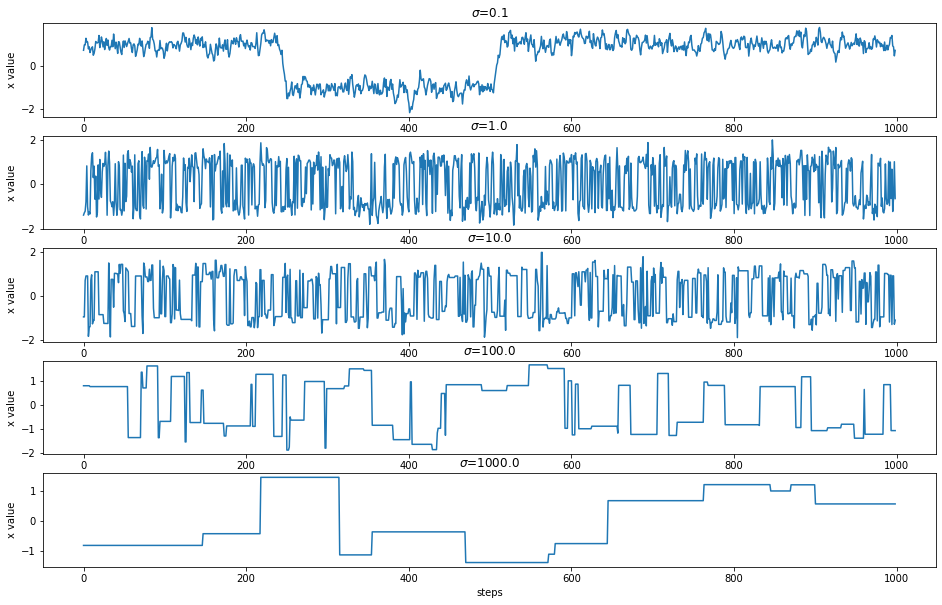

In [7]:
# Plot the paths we take a cross the sample space for the Metropolis Hastings algorithm.
# No TODOS here, just observe the paths that the Metropolis Hastings algorithm takes for different sigmas.
fig, ax = plt.subplots(figsize=(16,10), nrows=5)

idxs = np.arange(all_points_total[0].shape[0])
for sigma, all_points, row in zip(sigmas, all_points_total, ax):
    row.plot(idxs, all_points, zorder=2)
    row.set_title("$\sigma$=" + str(sigma))
    row.set_xlabel("steps")
    row.set_ylabel("x value")

Now let's see how well we sampled from the true pdf $f(x)$ for each value of sigma.

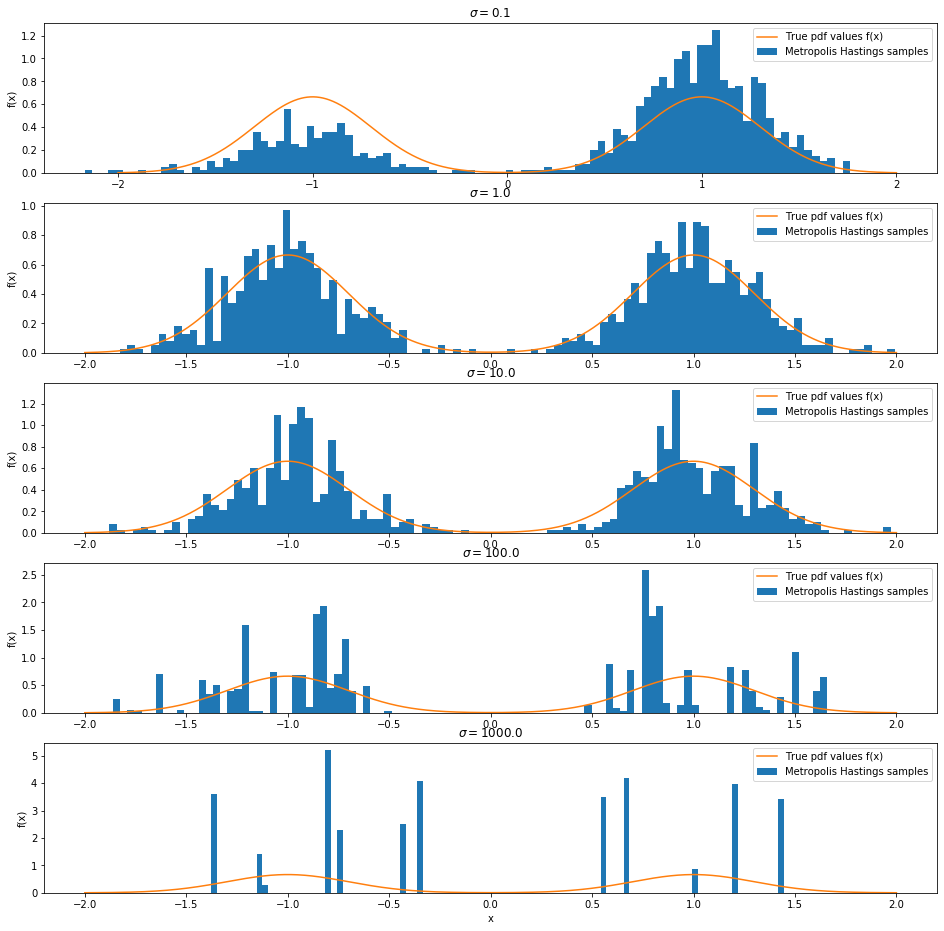

In [8]:
# Plot the pdf f(x) along with a histogram of the samples from Metropolis Hastings for each sigma.
# No TODOs here, just observe the plots and consider how well the Metropolis Hastings 
# algorithm did at sampling from f(x) for each sigma value.
fig, ax = plt.subplots(figsize=(16,16), nrows=5)

for sigma, samples, row in zip(sigmas, samples_total, ax):
    # Plot a histogram of all the samples we accepted.
    row.hist(samples, bins=100, density=True, label="Metropolis Hastings samples")
    # Now plot a curve of the true function, normalized to be a valid pdf, as a baseline.
    idxs = np.linspace(-2, 2, num=1000)
    row.plot(idxs, [objective_f_1d(i) for i in idxs], label="True pdf values f(x)")
    row.legend()
    row.set_title("$\sigma=$" + str(sigma))
    row.set_ylabel("f(x)")
plt.xlabel("x")
plt.show()

## 1c) Question: 
Qualitatively, which values of $\sigma$ do you think performed best at sampling from the distribution $f(x)$?
Can you explain why we observe the four sampling paths in the first set of plots?
How do you think performance (i.e. how well our Metropolis Hasting samples matched the pdf $f(x)$) is tied to the sampling paths we plotted above?

TODO: fill in your answer.

Answer: It seems that $\sigma=1.0$ performs best followed by $\sigma=10.0$. In the case of $\sigma=0.1$ the sampling path spends more time in one peak. In the case of $\sigma=1000$ the proposal function nearly always proposes values that get rejected so we spend much too long around one area. The other values of $\sigma$ seem to be set such that we explore enough without proposing values that will get rejected which leads to good performance.

# 2) Moving the modes farther apart
Next, we will observe what happens when the pdf $f(x)$ that we want to sample from has modes that are farther apart.

To observe this, we will change the means of the two Gaussian distributions in $f(x)$ to be $\mu_1 = -2, \mu_2=2$.

In [25]:
# Define the pdf that we want to sample from, f(x), with modes farther apart.
# No TODOs here, just run this cell to initialize the pdf we want to sample from.
def objective_f_1d_far(x, mu_1=-2, mu_2=2, sigma_1=0.3, sigma_2=0.3, weight_1 = 0.5, weight_2 = 0.5):
    """pdf for a 1-dimensional bimodal mixture of Gaussians distribution."""
    return weight_1*scipy.stats.norm.pdf(x, mu_1, sigma_1) + weight_2*scipy.stats.norm.pdf(x, mu_2, sigma_2)

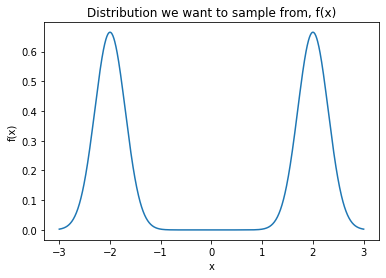

In [27]:
# Plot the distribution that we want to sample from, f(x) with modes farther apart.
# No TODOs here, just run this cell to visualize f(x).
plt.title("Distribution we want to sample from, f(x)")
idxs = np.linspace(-3, 3,num=1000)
plt.plot(idxs, [objective_f_1d_far(i) for i in idxs])
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

## Evaluating Metropolis Hastings
Now that we have our algorithm let's see how well it approximates the objective function. We will try running Metropolis Hastings with four different values of $\sigma$ to see how it affects the performance. 

In [28]:
# Run the Metropolis Hastings algorithm to sample from f(x).
# No TODOs here, just run this cell to run the algorithm implemented above.
samples_total = []
all_points_total = []
sigmas = [0.1, 1.0, 10.0, 100.0, 1000.0]
for sigma in sigmas:
    samples, all_points = metropolis_hastings(num_draws=10000,
                                              burn_in_steps=1000,
                                              sample_frequency=10,
                                              sigma=sigma, 
                                              objective_f_input=objective_f_1d_far,
                                              d_input=1)
    samples_total.append(samples)
    all_points_total.append(samples)

Now let's plot the paths we take across the samples space for the different values of sigma.

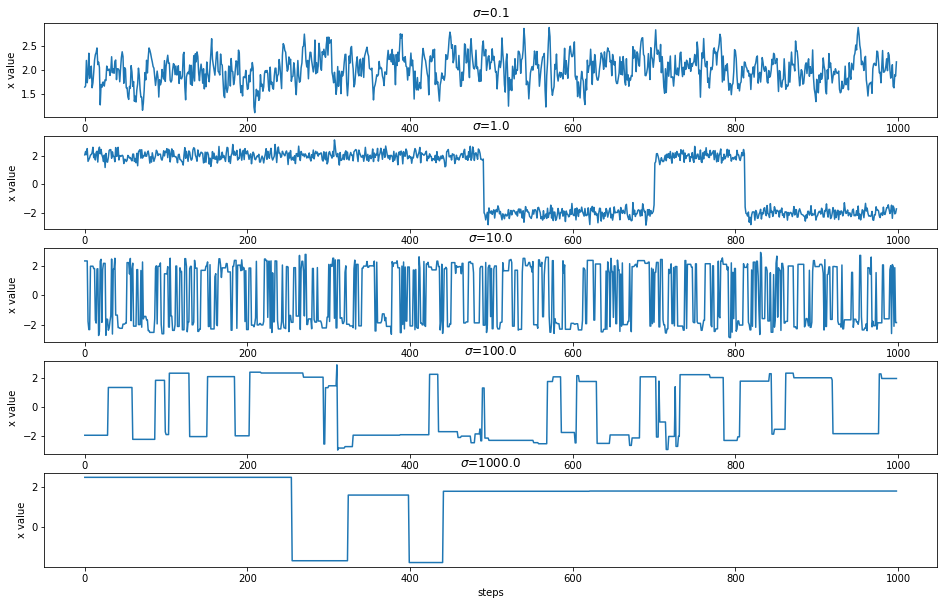

In [29]:
# Plot the paths we take a cross the sample space for the Metropolis Hastings algorithm.
# No TODOS here, just observe the paths that the Metropolis Hastings algorithm takes for different sigmas.
fig, ax = plt.subplots(figsize=(16,10), nrows=5)

idxs = np.arange(all_points_total[0].shape[0])
for sigma, all_points, row in zip(sigmas, all_points_total, ax):
    row.plot(idxs, all_points, zorder=2)
    row.set_title("$\sigma$=" + str(sigma))
    row.set_xlabel("steps")
    row.set_ylabel("x value")

Now let's see how well we sampled from the true pdf $f(x)$ for each value of sigma.

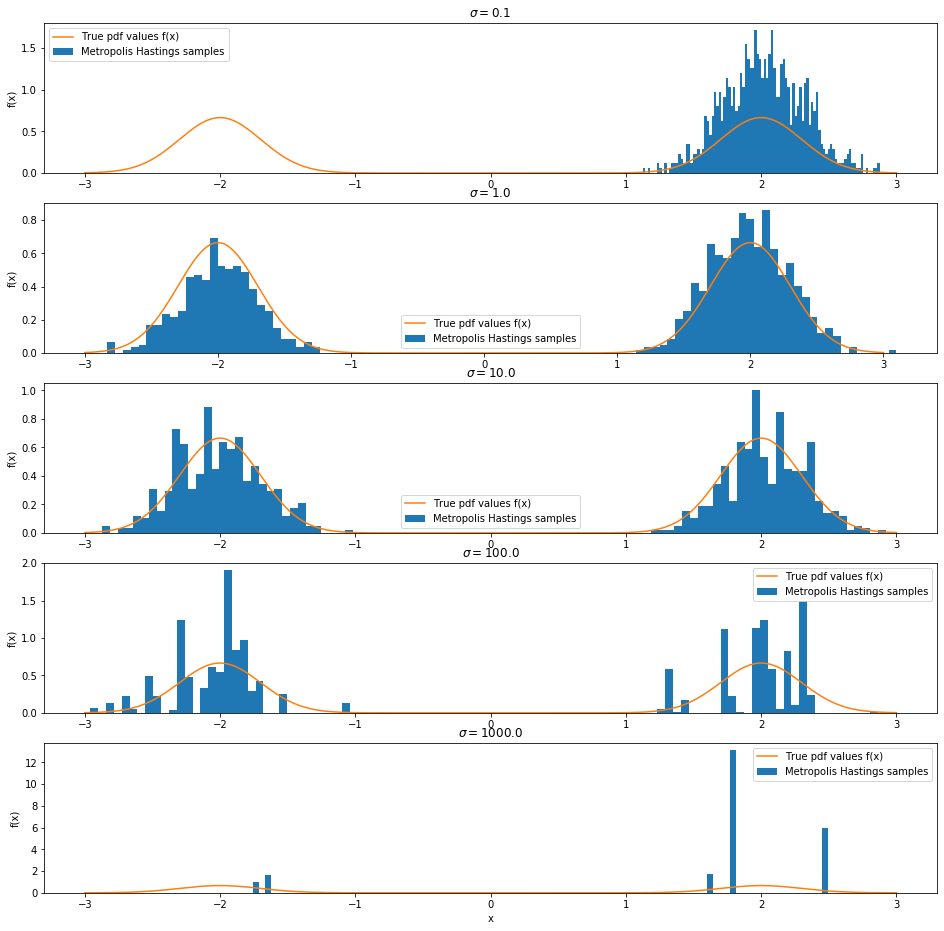

In [30]:
# Plot the pdf f(x) along with a histogram of the samples from Metropolis Hastings for each sigma.
# No TODOs here, just observe the plots and consider how well the Metropolis Hastings 
# algorithm did at sampling from f(x) for each sigma value.
fig, ax = plt.subplots(figsize=(16,16), nrows=5)

for sigma, samples, row in zip(sigmas, samples_total, ax):
    # Plot a histogram of all the samples we accepted.
    row.hist(samples, bins=100, density=True, label="Metropolis Hastings samples")
    # Now plot a curve of the true function, normalized to be a valid pdf, as a baseline.
    idxs = np.linspace(-3, 3, num=1000)
    row.plot(idxs, [objective_f_1d_far(i) for i in idxs], label="True pdf values f(x)")
    row.legend()
    row.set_title("$\sigma=$" + str(sigma))
    row.set_ylabel("f(x)")
plt.xlabel("x")
plt.show()

## 2a) Question: 
Qualitatively, which values of $\sigma$ do you think performed best at sampling from the distribution $f(x)$? Is the best value of $\sigma$ different when the modes are farther apart compared to when they were closer together as in part 1)?

TODO: fill in your answer.

Answer: When the modes are farther apart, the best $\sigma$ was actually $\sigma=10$, since it managed to sample more evenly from both modes.

# 3. Sampling in higher dimensions
Next, we will try Metropolis-Hastings sampling in higher dimensions. This time, we will consider a bimodal mixture of *multivariate* Gaussian distributions in $d=5$ dimensions. Specifically, for $x \in \mathbb{R}^{d}$, the probably density function that we want to sample from is $$f(x) = \frac{1}{2} \phi_1(x) + \frac{1}{2} \phi_2(x), $$ where $\phi_1$ and $\phi_2$ are each probability density functions for $d$-dimensional multivariate Gaussian distributions with means $\mu_1$ and $\mu_2$ and covariance matrices $\Sigma_1$ and $\Sigma_2$ respectively.

Specifically, given means $\mu_1$, $\mu_2 \in \mathbb{R}^{d}$ and covariance matrices $\Sigma_1, \Sigma_2 \in \mathbb{R}^{d \times d}$, we have
$$\phi_1(x) = (2\pi)^{-d/2}\det(\Sigma_1)^{-1/2} e^{-\frac{1}{2}(x - \mu_1)^T\Sigma_1^{-1}(x - \mu_1)}$$ and 
$$\phi_2(x) = (2\pi)^{-d/2}\det(\Sigma_2)^{-1/2} e^{-\frac{1}{2}(x - \mu_2)^T\Sigma_2^{-1}(x - \mu_2)}$$


In [14]:
# We define the objective function for d=5.
# Note: no TODOs here, just run this cell.
def objective_f_5d(x, d=5, mu_1=-1, mu_2=1, sigma_1=0.3, sigma_2=0.3, weight_1 = 0.5, weight_2 = 0.5):
    """pdf for a d-dimensional bimodal mixture of Gaussians distribution. 
    The input x is expected to be a d-dimensional array."""
    return weight_1*scipy.stats.multivariate_normal.pdf(x, np.ones(d)*mu_1, sigma_1) + weight_2*scipy.stats.multivariate_normal.pdf(x, np.ones(d)*mu_2, sigma_2)

## Projection function for visualization
Since we're now sampling from a 5-dimensional distribution $f(x)$, we need to define a projection function in order to visualize the data. Specifically, we will project all 5-dimensional points $x \in \mathbb{R}^d$ down to 1 dimension by simply taking the sum of all of the coordinates of $x$. This effectively projects the points $x \in \mathbb{R}^d$ onto the line $y = x$. For a detailed explanation on why that projection works, see [this link](https://en.wikibooks.org/wiki/Linear_Algebra/Orthogonal_Projection_Onto_a_Line).

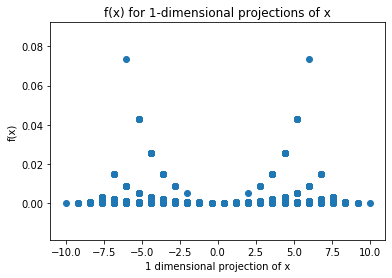

In [15]:
# Here we will visualize the pdf that we want to sample from f(x) by plotting f(x) against the 1d projections of x.
# Note: no TODOs here, just understand how we're getting the 1d projections on the x axis.
d = 5
def project_1d(x):
    """Projects a d-dimensional vector x down to 1 dimension by simply summing the coordinates."""
    return np.sum(x)

# Get a grid of all d-dimensional vectors x between (-2,-2,...,-2) and (2,2,...,2)
possible_x_vals = [np.linspace(-2, 2, num=6) for _ in range(d)]
possible_xs = list(product(*possible_x_vals))

# Compute the 1d projections for all d-dimensional vectors in the grid.
projected_xs = [project_1d(x) for x in possible_xs]

# Compute the pdfs f(x) for all d-dimensional vectors in the grid. 
pdf_xs = [objective_f_5d(x) for x in possible_xs]

# Plot the pdf values f(x) against the 1d projections of x.
plt.title("f(x) for 1-dimensional projections of x")
plt.scatter(projected_xs, pdf_xs)
plt.xlabel("1 dimensional projection of x")
plt.ylabel("f(x)")
plt.show()

## Proposal distribution for Metropolis Hastings in d-dimensions
Similar to what we did in 1-dimension, now let's define the proposal distribution for our Metropolis Hastings algorithm in d-dimensions.

In d-dimensions, we will pick a multivariate Gaussian proposal distribution:
$$v(x'|x) = \mathcal{N}(x'; x, \sigma^2 I).$$
The proposal distribution has mean $x \in \mathbb{R}^d$ and covariance matrix $\sigma^2I$. We will again pick $\sigma$ later.

The probability $\alpha$ of us accepting the new sample is again given by
$$\min{\left(1, \frac{f(x')v(x|x')}{f(x)v(x'|x)}\right)},$$
where $f: \mathbb{R}^d \to \mathbb{R}$ is the pdf we wish to sample from.

For Metropolis Hastings sampling in d-dimensions, we will reuse many of the same functions from before.

In [16]:
# Sample points using Metropolis Hastings.
samples_total = []
all_points_total = []
sigmas = [0.1, 1.0, 10.0, 100.0, 1000.0]
for sigma in sigmas:
    samples, all_points = metropolis_hastings(num_draws=10000,
                                              burn_in_steps=1000,
                                              sample_frequency=10,
                                              sigma=sigma,
                                              objective_f_input=objective_f_5d,
                                              d_input=5)
    samples_total.append(samples)
    all_points_total.append(samples)

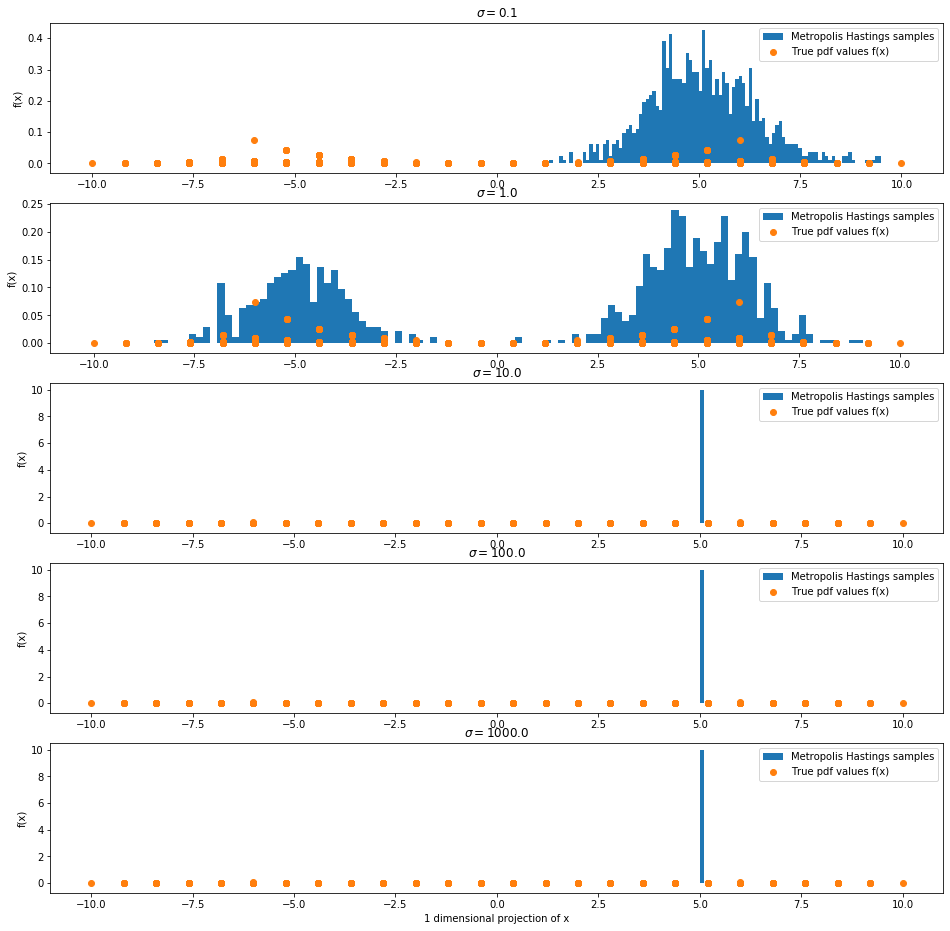

In [19]:
# Plot a histogram of all the samples we accepted in terms of their 1d projections.
# Note: no TODOs here, just run this cell and observe the plots.

fig, ax = plt.subplots(figsize=(16,16), nrows=5)

for sigma, samples, row in zip(sigmas, samples_total, ax):
    # Project row examples down to 1d. 
    samples_1d = [project_1d(x) for x in samples]
    bins=100
    # Reduce the number of histogram bins for large sigma so that bars aren't too tiny to visualize.
    if sigma > 1.0:
        bins = 10
    row.hist(samples_1d, bins=bins, density=True, zorder=1, label="Metropolis Hastings samples")
    # Now plot a curve of the true pdf as a baseline.
    row.scatter(projected_xs, pdf_xs, color='C1', zorder=10, label="True pdf values f(x)")
    row.legend()
    row.set_title("$\sigma=$" + str(sigma))
    row.set_ylabel("f(x)")
plt.xlabel("1 dimensional projection of x")
plt.show()

## 3a) Question: 
Which value of $\sigma$ was most successful at sampling in $d=5$ dimensions? Did the performance of the Metropolis Hastings algorithm appear more sensitive or less sensitive to the choice of $\sigma$ for $d=5$ compared to $d=1$?

TODO: fill in your answer.

Answer: It again seems that $\sigma=1.0$ performs best. The Metropolis Hastings algorithm was more sensitive to the choice of $\sigma$ for $d=5$, since choosing $\sigma = 100$ or $\sigma=1000$ cause the algorithm to basically not accept any new samples after the initial one.